# 3D Wing shape optimization via Reinforcement Learning

This example wiill show how to train an agent that optimizes wings.

## Define operating conditions

In [ ]:
from pyLOM.RL import (
    create_env,
    WingOperatingConditions,
    WingParameterizerConfig,
    AerosandboxWingSolver,
)

from stable_baselines3 import PPO

import torch

# training should be faster with single thread
torch.set_num_threads(1)

In [2]:
operating_conditions = WingOperatingConditions(
    alpha=2.0,
    altitude=500,
    velocity=200,
)

## Shape parameterization and design space

To parametrize the wing secntions and regions need to be defined. Each secion is defined by its chord length, an airfoil and a twist. Each region is defined by its lenght (span) and the 2 angles formed by the secions (sweep and diherdal). Note that there must be one more section than regions.  
Similar to the 2D case, we can use `AirfoilCSTParametrizer` directly or `AirfoilParameterizerConfig`, that will create an instance of `AirfoilCSTParametrizer` with some default parameters

In [3]:
parameterizer = WingParameterizerConfig().create_parameterizer()

Here is an example of how a wing can be created from its parameters using the parameterizer. Note that since the default parameterizer has only 2 sections and 1 region, the parameters must have exactly 2 sections and 1 region, otherwise it will not work. To use more secions, other parameterizer defined for more sections would be required

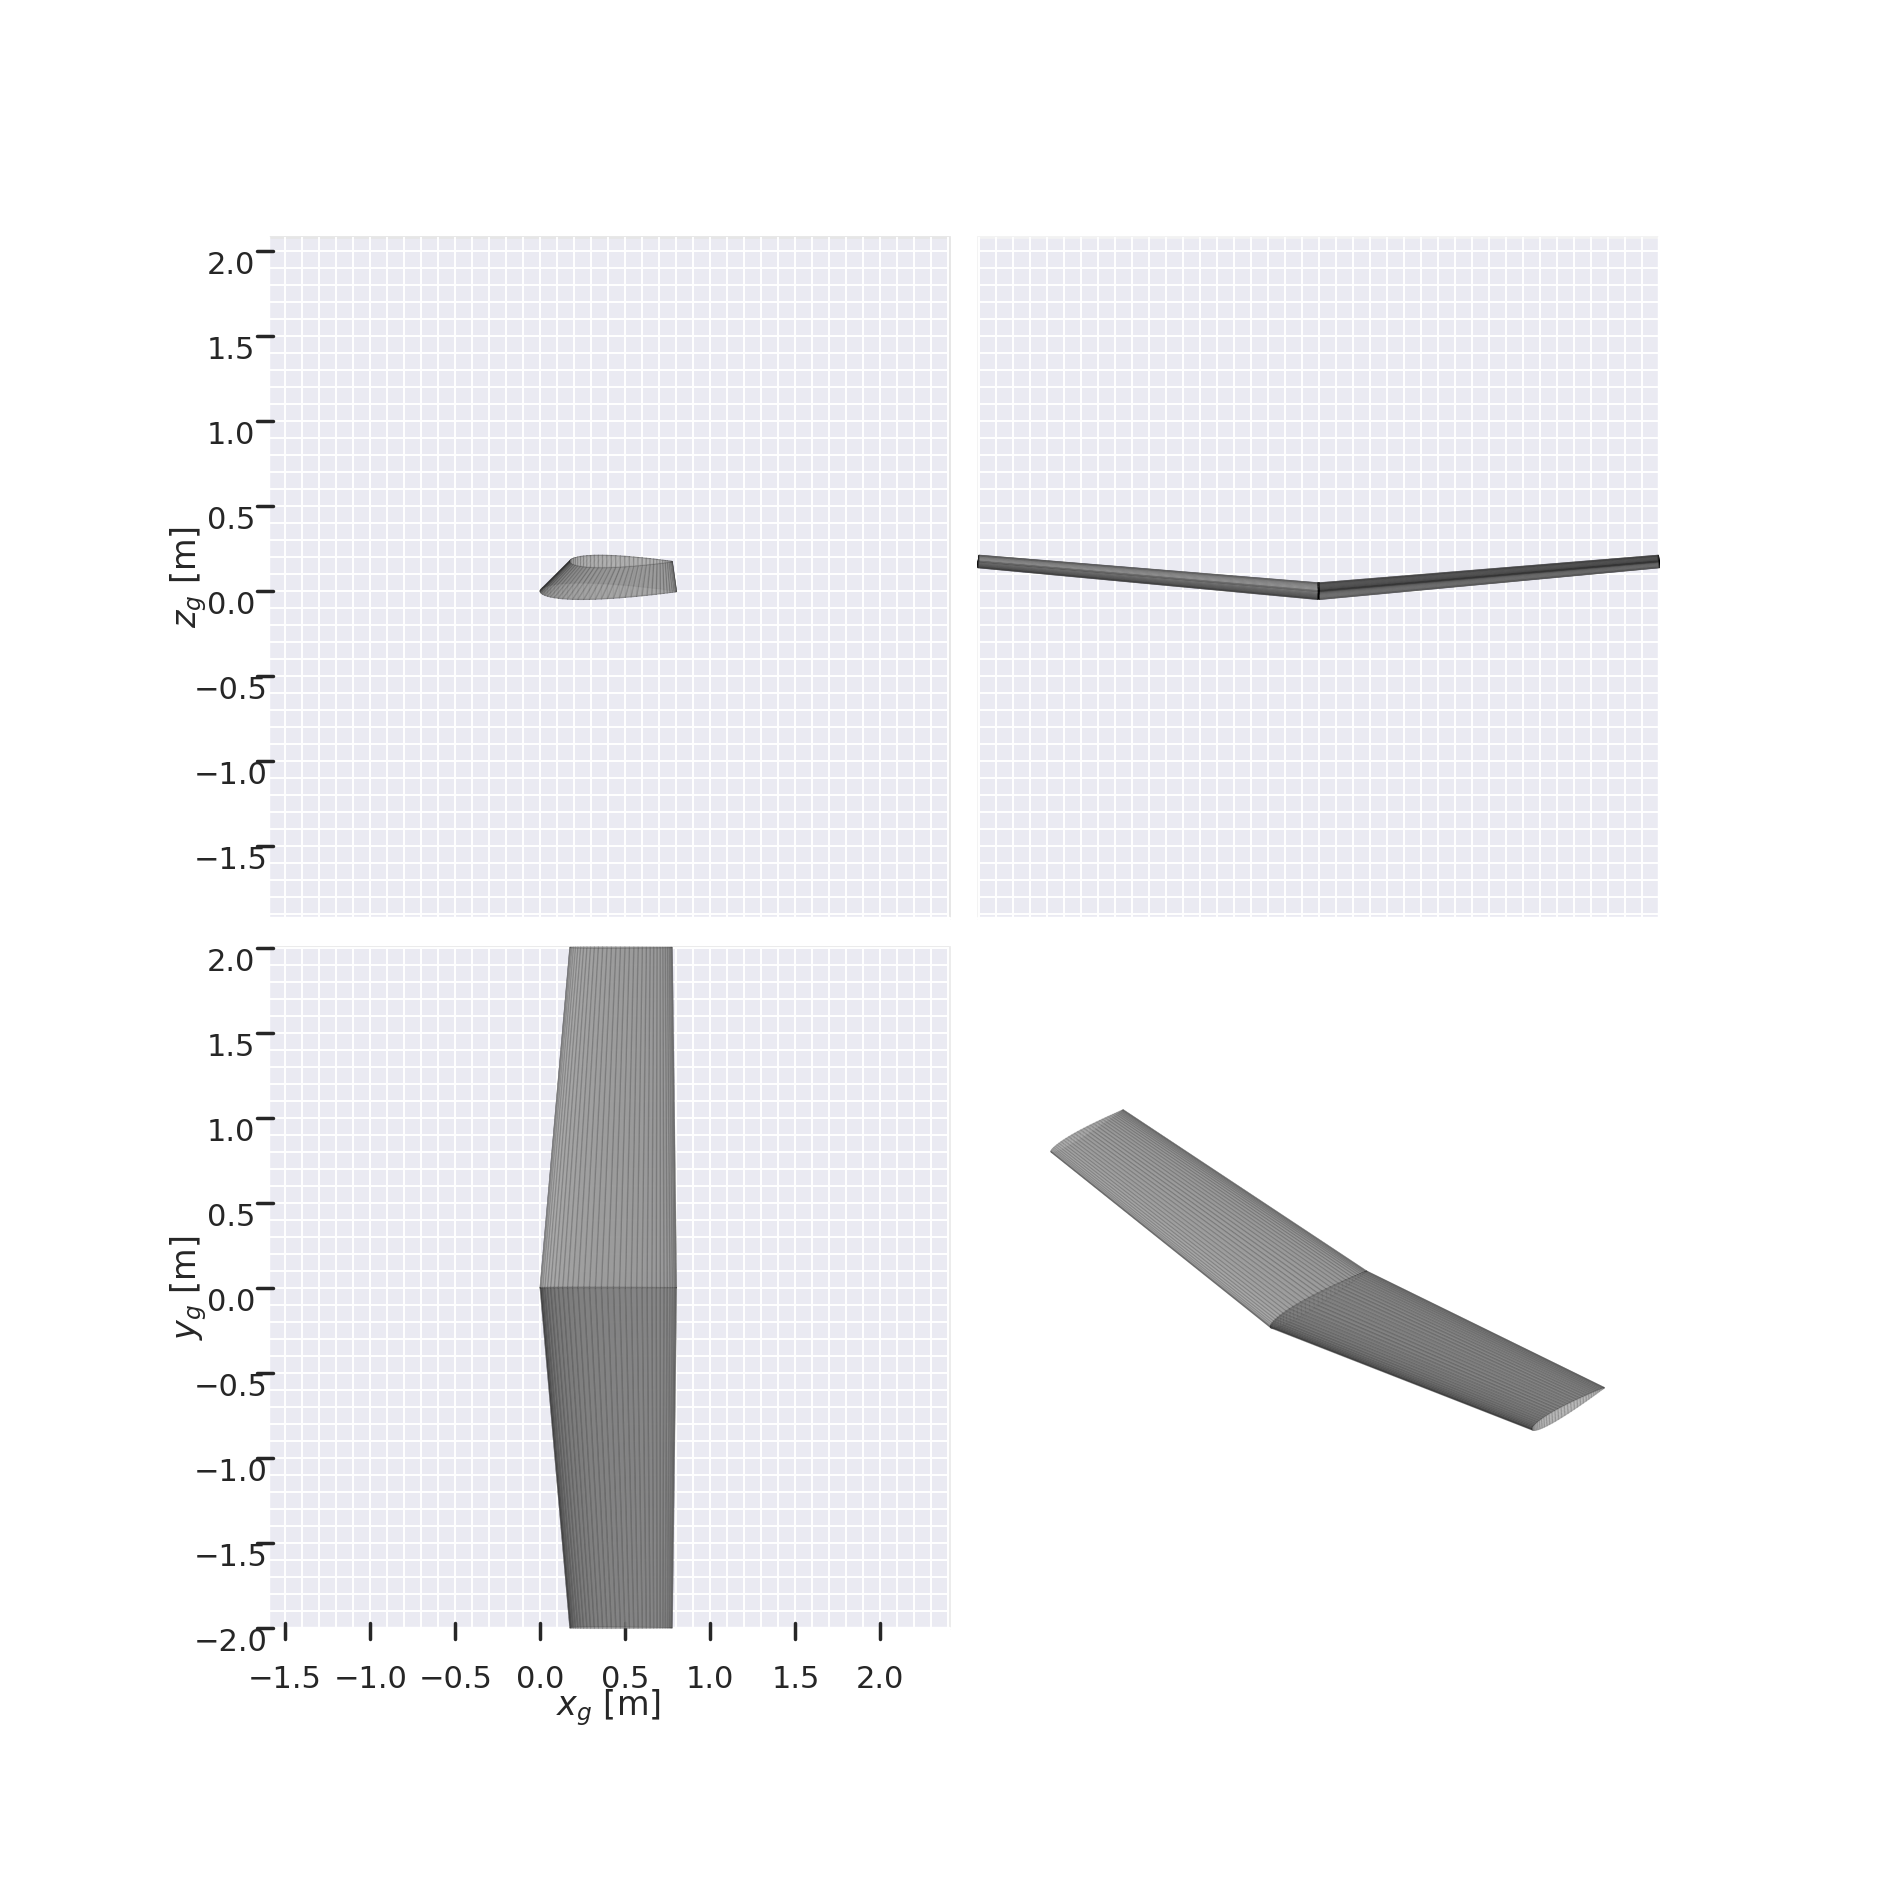

array([[<Axes3D: zlabel='$z_g$ [m]'>, <Axes3D: >],
       [<Axes3D: xlabel='$x_g$ [m]', ylabel='$y_g$ [m]'>, <Axes3D: >]],
      dtype=object)

In [4]:
chords = [0.8, 0.6]
twists = [0.1, 0.2]
spans = [2.0]
sweeps = [5]
diheds = [5]

wing_params = chords + twists + spans + sweeps + diheds

wing = parameterizer.get_shape_from_params(wing_params)
wing.draw_three_view()

We can generate too a random wing within the desing parameters bounds

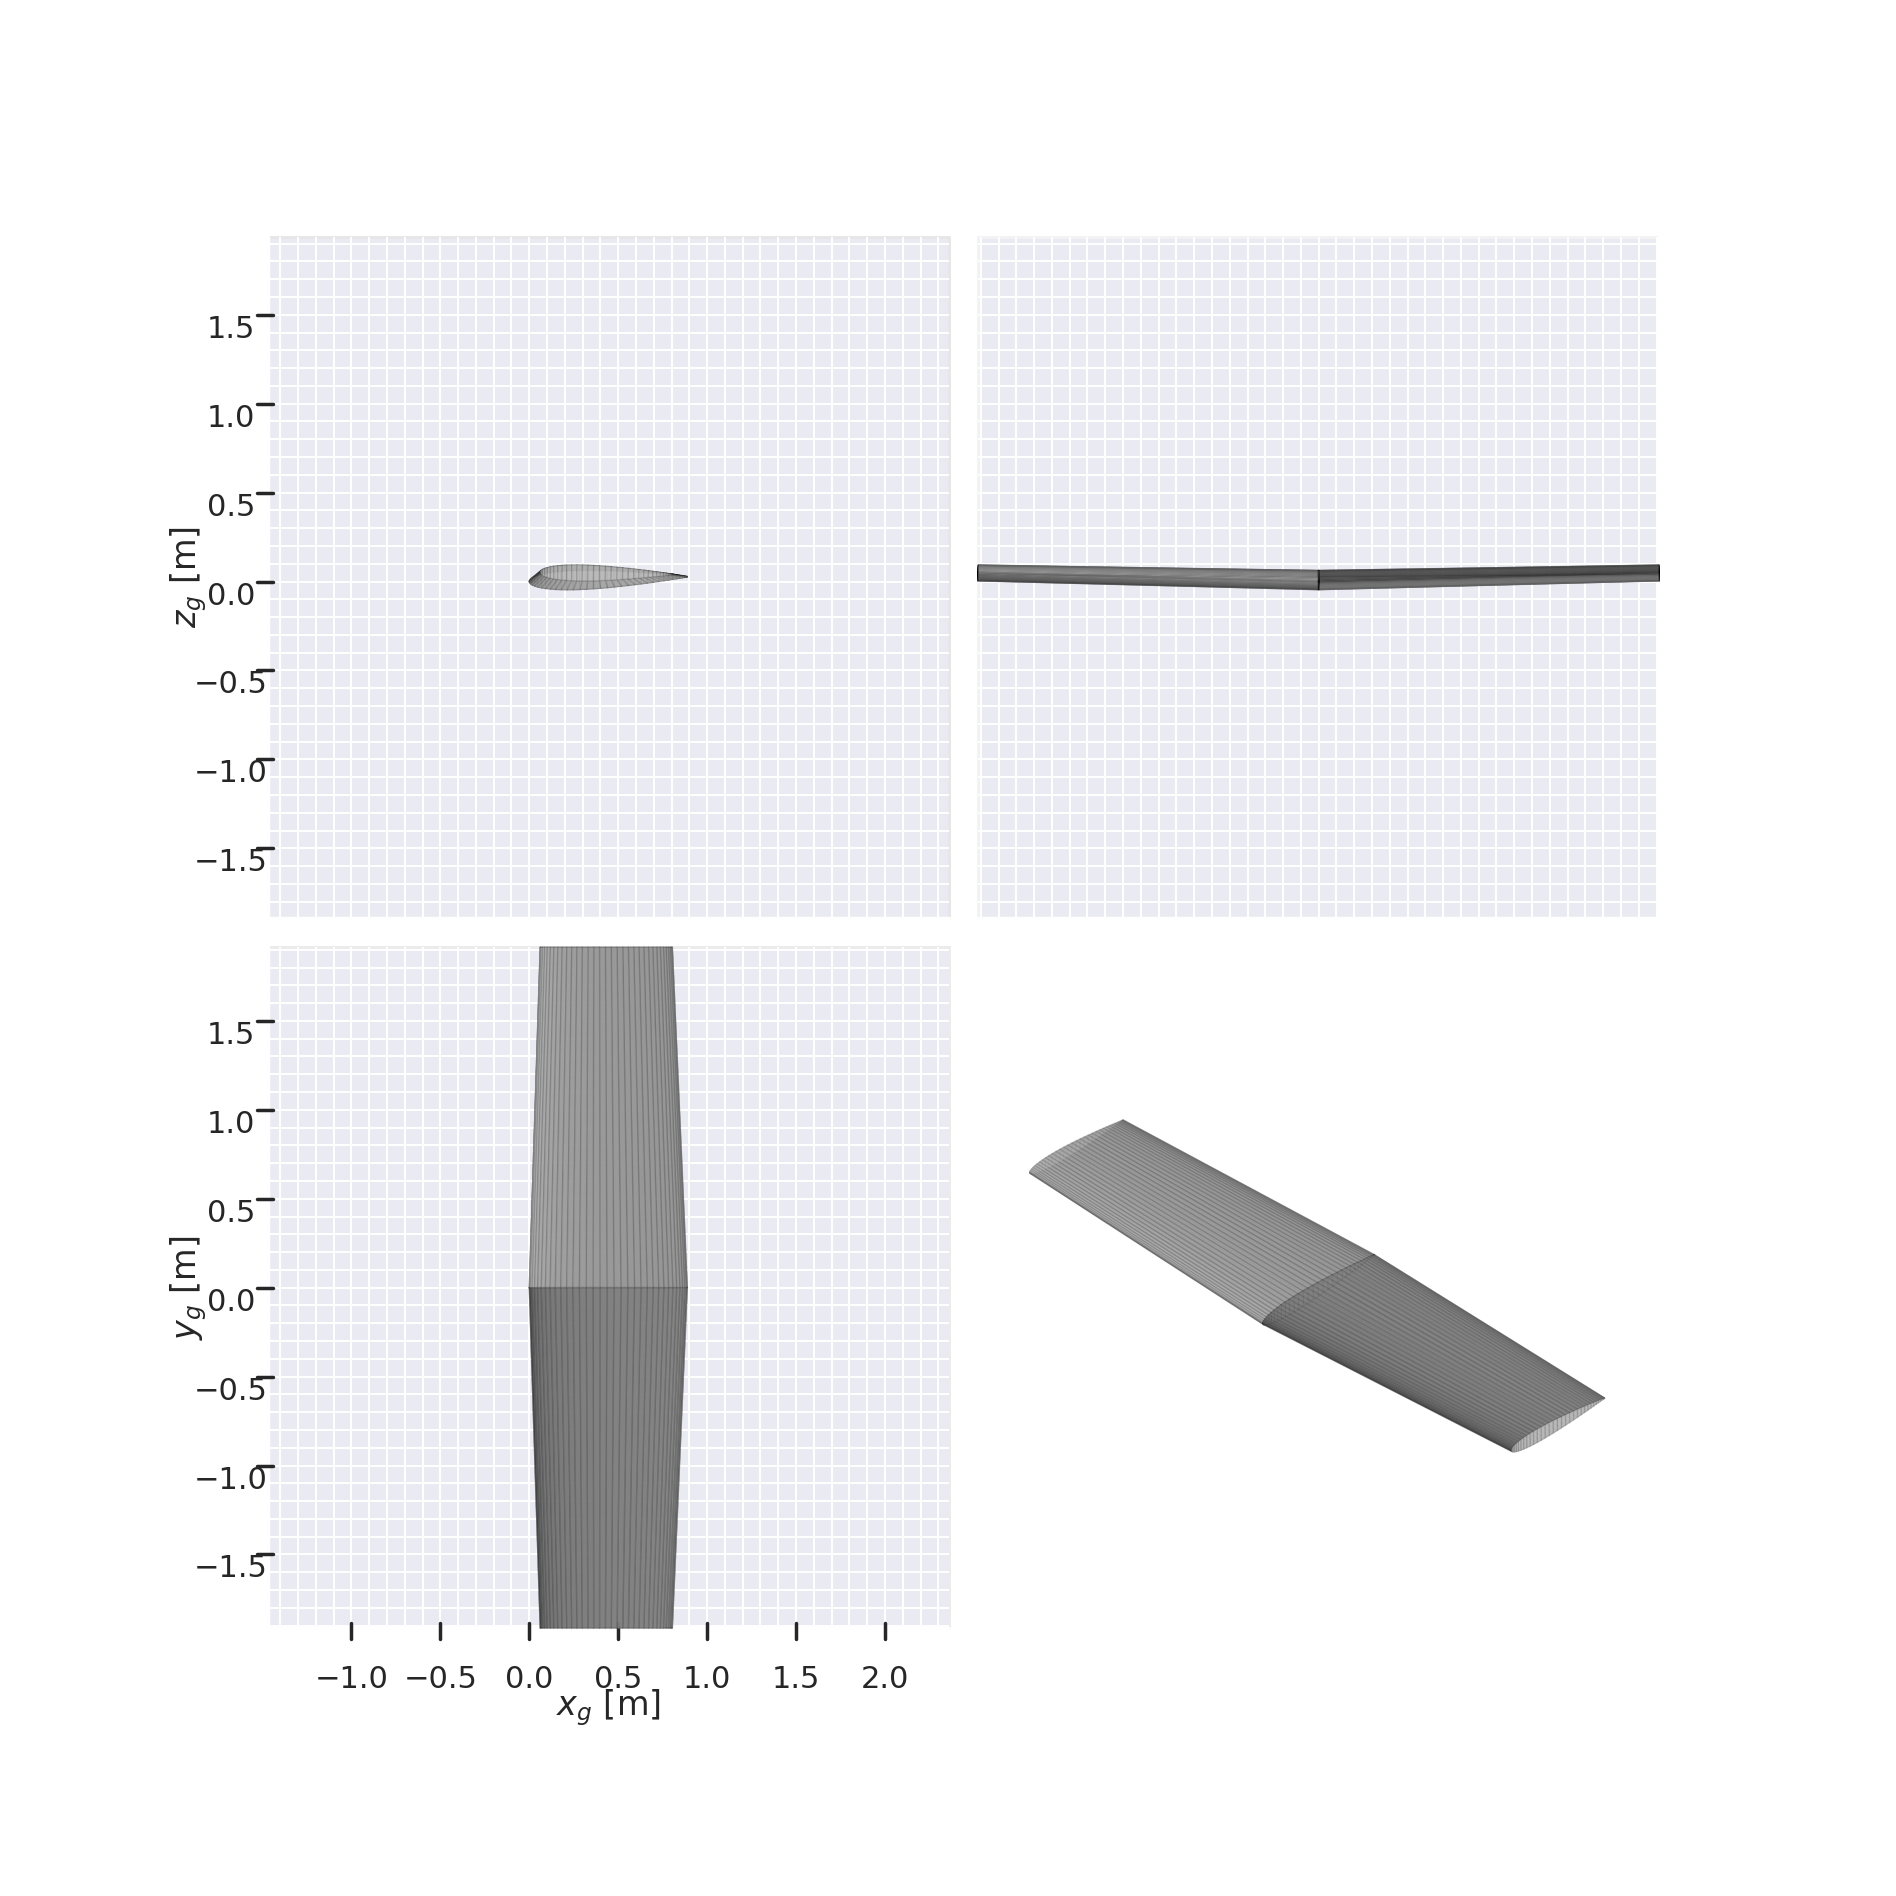

array([[<Axes3D: zlabel='$z_g$ [m]'>, <Axes3D: >],
       [<Axes3D: xlabel='$x_g$ [m]', ylabel='$y_g$ [m]'>, <Axes3D: >]],
      dtype=object)

In [5]:
random_wing_params = parameterizer.generate_random_params()
wing = parameterizer.get_shape_from_params(random_wing_params)
wing.draw_three_view()

## Define the solver

As in the airfoil example, a solver is needed. In this case the 3D solver integrated in aerosandbos will be used

In [6]:
solver = AerosandboxWingSolver(
    alpha=operating_conditions.alpha,
    atmosphere=operating_conditions.atmosphere, # this is created automatically when the altitude is defined
    velocity=operating_conditions.velocity,
)

## Create the environment

The enviroment can be created either with `gym.make` or with `create_env`. For this example parallel environment will be used to speed up the training, so `create_env` will be easier to use.

In [ ]:
# env = gym.make(
#     "ShapeOptimizationEnv-v0",
#     solver=solver,
#     parameterizer=parameterizer,
#     episode_max_length=64,
# )
NUM_ENVS = 8
env = create_env(
    "aerosandbox",
    operating_conditions=operating_conditions,
    episode_max_length=64,
    parameterizer=parameterizer,
    num_envs=NUM_ENVS,
)

## Define the PPO agent and train it on the environment

We define the hyperparameters here to train an agent. Since parallel environments are used, `n_steps`, which indicates after how many steps the weights of the agent are updated, needs to be divided by the number of environments

In [ ]:
ppo_parameters = {
    'learning_rate': 2.5e-4,
    'n_steps': 2048 // NUM_ENVS, 
    'batch_size': 32,
    'n_epochs': 20,
    'gamma': 0.3,
    'gae_lambda': 0.95,
    'clip_range': 0.4,
    'ent_coef': 0.005,
    'verbose': 1,
    'policy_kwargs': {'net_arch': dict(pi=[256, 256], vf=[256, 256])},
}
training_timesteps = 15000

model = PPO("MlpPolicy", env, **ppo_parameters)

Using cpu device


In [ ]:
model.learn(total_timesteps=training_timesteps)
model.save("wing_agent")

If you want to use a model that is already trained you can load it

In [9]:
model = PPO.load("wing_agent")

## Test the agent

Evaluation for the 3D optimization is easier because we can evaluate the agent with the random resets of the environment. Thus, the built-it fucntion `evaluate_policy` from stable baselines 3 can be used

In [10]:
from pyLOM.RL import (
    run_episode,
)
from stable_baselines3.common.evaluation import evaluate_policy

First, an `eval_env` is defined without parallelization. Then an initial wing is randomly generated, but note that any `abs.Wing` within the bounds of the parameterizer can be optimized

/home/david/miniconda/envs/pylom-rl/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/home/david/miniconda/envs/pylom-rl/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(
/home/david/miniconda/envs/pylom-rl/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:134: UserWarning: WARN: The obs returned by the `reset()` method was expecting numpy array dtype to be float32, actual type: float64
  logger.warn(
/home/david/miniconda/envs/pylom-rl/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:158: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


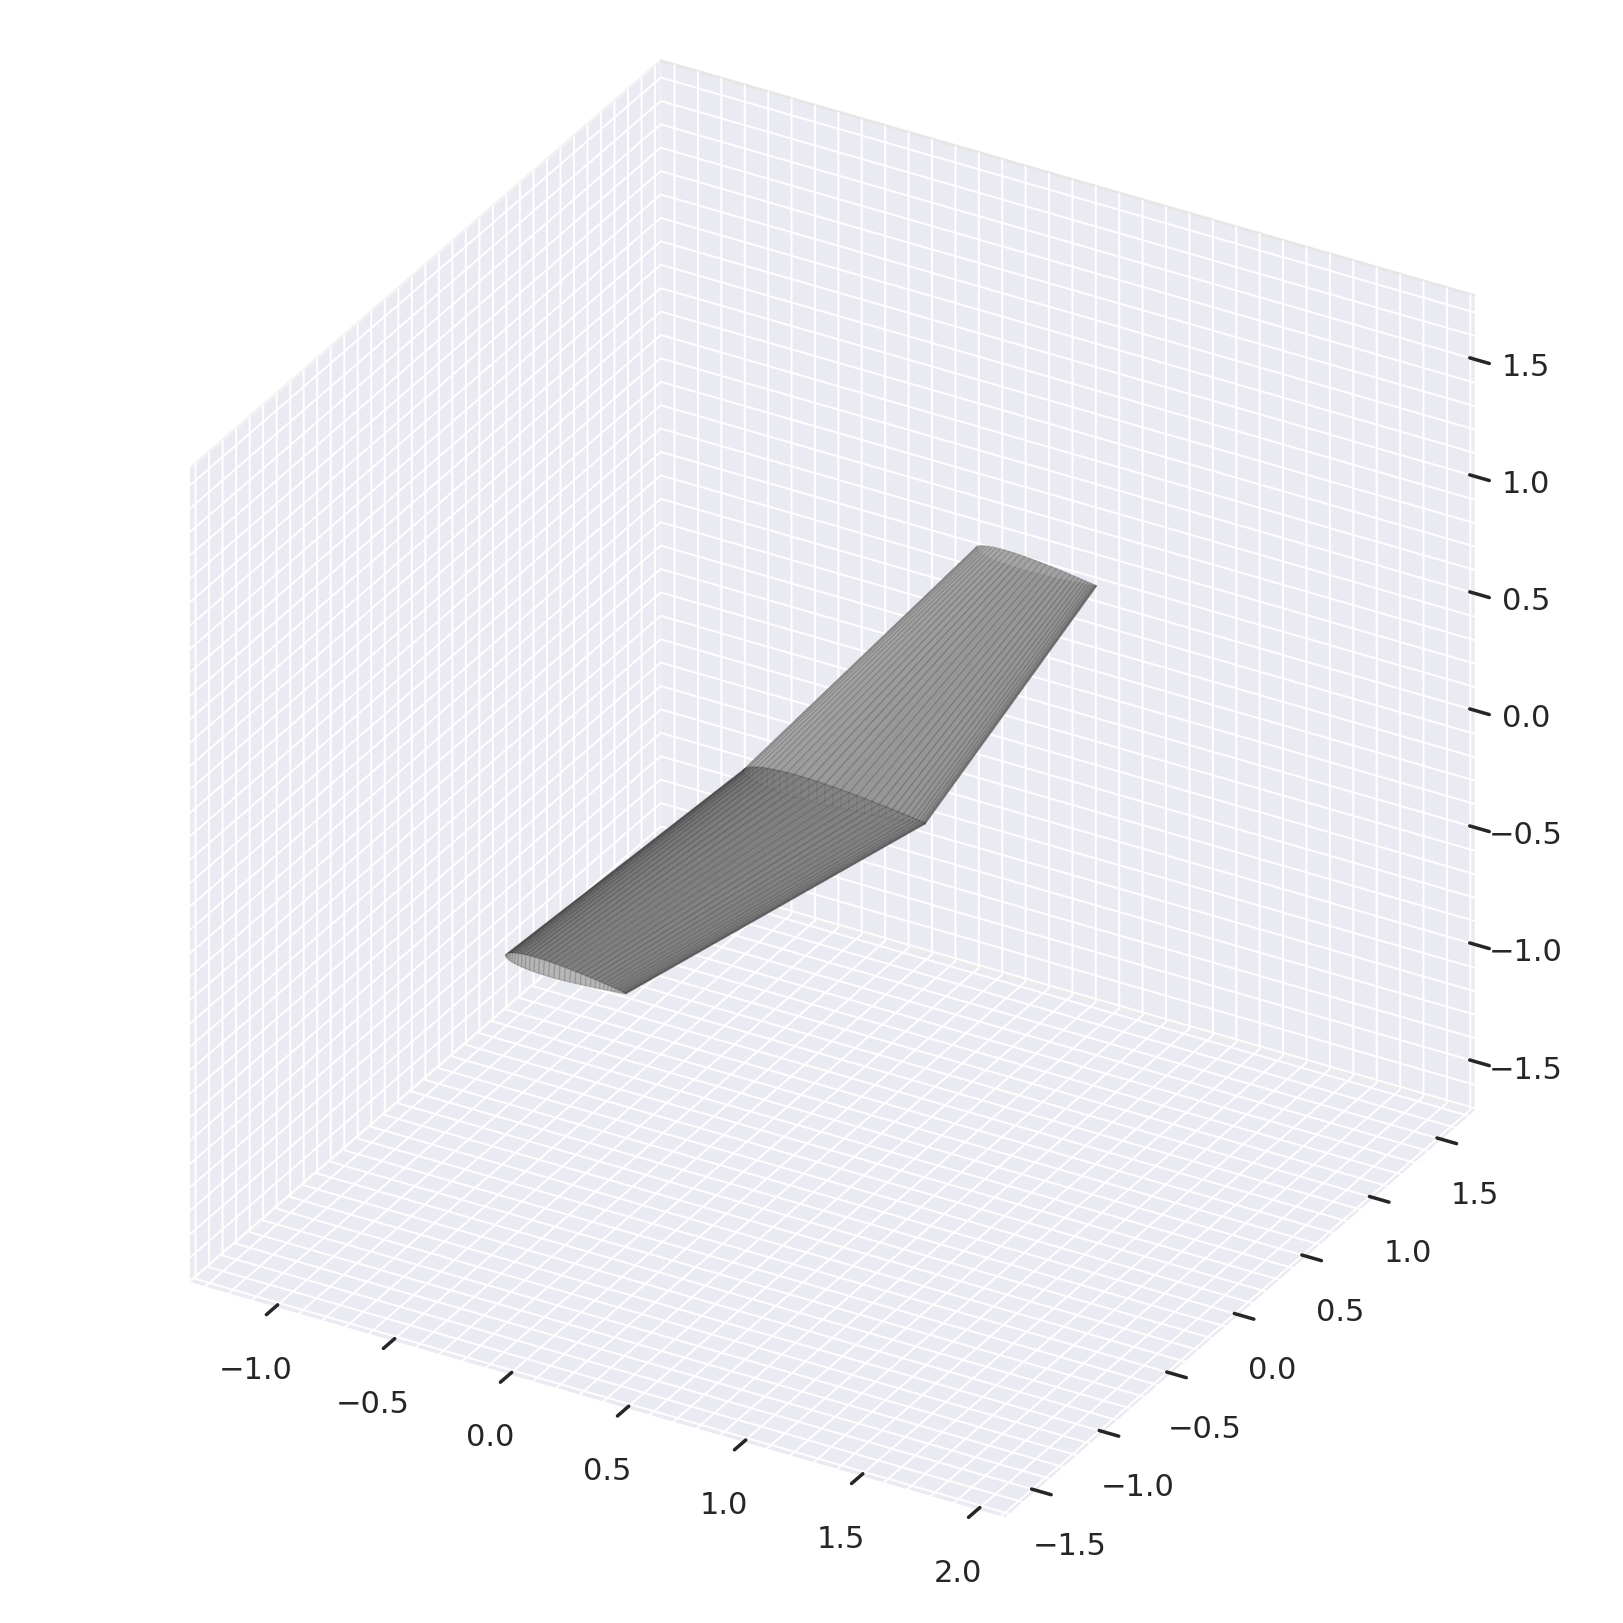

In [11]:
eval_env = create_env(
    "aerosandbox",
    operating_conditions=operating_conditions,
    episode_max_length=64,
    parameterizer=parameterizer,
    num_envs=1,
)
obs, info = eval_env.reset()
initial_wing = info['shape']
initial_wing.draw(backend="matplotlib")

In [12]:
mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=20, warn=False)

In [13]:
print(f"Mean CL/CD improvement: {mean_reward:.2f} +/- {std_reward:.2f}")

Mean CL/CD improvement: 7.38 +/- 4.30


(None, Wing 'Main Wing' (2 xsecs, symmetric))

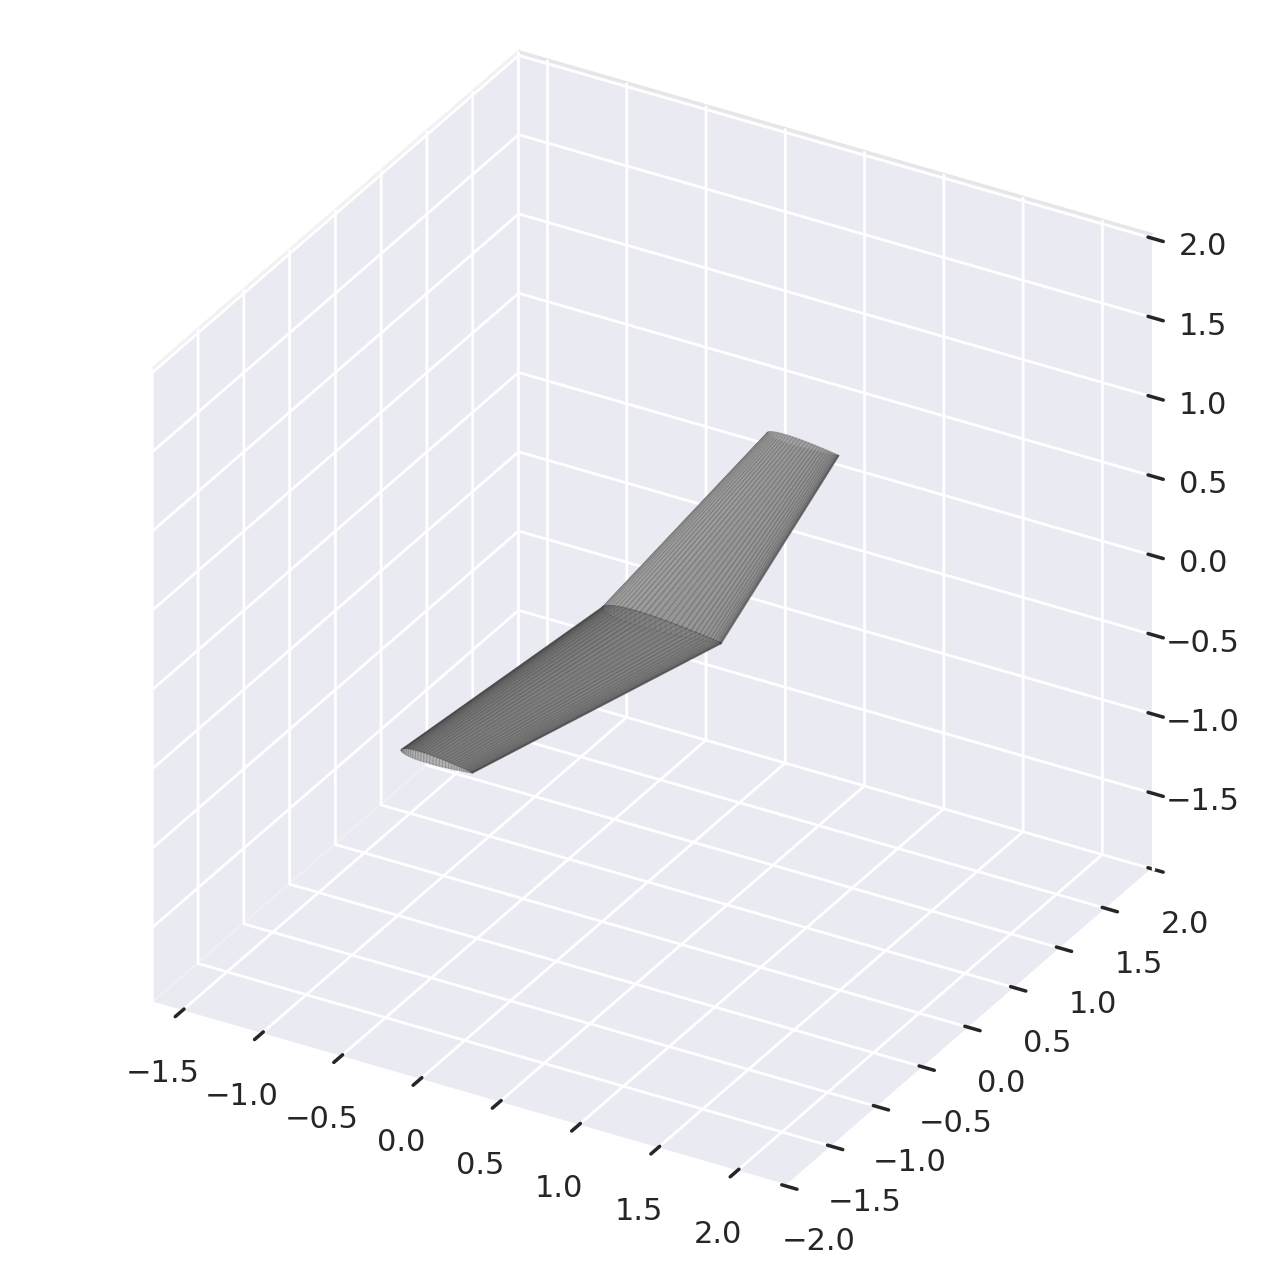

In [14]:
rewards, states = run_episode(model, eval_env, initial_shape=initial_wing)
eval_env.render()

States contains the parameters of the wings, but if we want to visualize them we need `asb.Wing` objects. Similar to the airfoil example, we can convert them with the parameterizer

In [15]:
wings = list(map(lambda x: parameterizer.get_shape_from_params(x), states))

Now any intermediate wing of the optimization can be visualized. A similar animation to the airfoil example of the optimization process is available too, but for that you will need to install manim with `conda install -c conda-forge manim`.   

If the video generation takes too long you can adjust the quality changing the "-qp" option:  
* -ql: for low quality
* -qm: for medium quality
* -qh: for high quality 
* -qp: for production quality (the highest)

In [16]:
from pyLOM.RL import WingEvolutionAnimation
from manim import *

In [ ]:
%%manim -qp -v WARNING WingEvolutionAnimation

WingEvolutionAnimation.wings = wings
WingEvolutionAnimation.rewards = rewards
WingEvolutionAnimation.run_time_per_update = 0.1

This is a small trick to actually show the resulting video on the documentation, the code here is not relevant since the previous cell must have already shown it

In [18]:
import base64
from IPython.display import HTML
video_path = "./media/videos/notebook_examples/1440p60/_WingEvolution.mp4"

with open(video_path, "rb") as f:
    video_data = base64.b64encode(f.read()).decode()

HTML(f"""
<video width="800" controls>
    <source src="data:video/mp4;base64,{video_data}" type="video/mp4">
    Your browser does not support the video tag.
</video>
""")